# Henger illesztés RANSAC eljárással

Az előzőekben már megvizsgáltuk a gömb illesztés megoldását a RANSAC eljárással. Most adott pontokra egyenes körhengert szeretnénk illeszteni. A pontok koordinátái a `dat\cyl.dat` [állományban](./dat/cyl.dat) találhatók.

A henger illesztés esetében a legnehezebb feladat az 5 megadott koordinátájú ponton átmenő henger(ek) paramétereinek kiszámítása. Meg lehet ugyanis mutatni, hogy 4 pont még nem elég, viszont 5 pont esetében páros számú (0, 2, 4, 6) megoldás található. 

Az általunk követett megoldás Paul Zsombor-Murray, Sawsan El Fashny (2006) [cikkén](http://www.heldermann-verlag.de/jgg/jgg10/j10h2zsom.pdf) alapul. Sajnos a cikkben két képlet is hibásan jelent meg, így ezeket is meg kellett keresnünk és ki kellett javítanunk. Szerencsére a cikkben közölt 2.1-es számpélda segítségével és számítógépes algebrai rendszer alkalmazásával ez végül is sikerült. Az egyik hibás kifejezés az (5) összefüggés második egyenlete, amelynek második tagja $p_1a_2^2$ helyett helyesen $p_1^2a_2^2$. A másik hiba a (10) egyenlet $d_5$ együtthatójában van. Az együtthatóra vonatkozó kifejezés harmadik tagja $-b_1c_1$ helyett $-b_1c_2$. Az említett cikkben közölt eljárás egyébként 6-odfokú algebrai egyenlet megoldásán alapul, így viszonylag gyors számítási eljárásról van szó, ami a RANSAC szempontjából fontos, hiszen ezt az eljárást sokszor kell majd alkalmazni.

A számítás a következő lépésekből áll:
* egy adott speciális koordináta-rendszerbe transzformáljuk az 5 pontot
* felírunk egy hatodfokú polinomot a henger irányvektorának egyik komponensére a henger pontjainak alapegyenletéből kiindulva
* a másik komponens ezután lineáris egyenletből kiszámítható

A henger pontjainak alapegyenlete a következő:

$$(\mathbf{x}\times\mathbf{a})^2 -2\mathbf{a}^2(\mathbf{x}\cdot\mathbf{a}) = 0 ,$$

ahol $\mathbf{x}$ a henger tetszőleges pontjának helyvektora, $\mathbf{a}$ a henger tengelyének irányába mutató vektor. Az $\mathbf{f}$ vektor az $O$ kezdőpontból a henger tengelyének egy pontjába mutat és merőleges az $\mathbf{a}$ vektorra ($\mathbf{a}\cdot\mathbf{f}=0$).

Minden megadott pontra fel tudunk írni egy ilyen egyenletet, de mivel a koordináta-rendszerünk $O$ kezdőpontját tetszőlegesen vehetjük fel (például azonos lesz az első ponttal), ezért csak 4 ilyen egyenletünk lesz a 6 ismeretlenre (ezek az $\mathbf{a}$ és $\mathbf{f}$ vektorok összetevői). A merőlegességi feltétel az 5. egyenlet.

Mivel az $\mathbf{a}$ vektor hossza tetszőleges (például legyen egységnyi, $\mathbf{a}^2=1$; csak az iránya lényeges), ezért csupán 5 ismeretlen van, így 5 egyenlet valóban elég. Megemlítjük még, hogy a kapott $\mathbf{f}$ vektor hossza adja meg a henger sugarát.

Először megírjuk az 5 pont alapján egyenes körhenger paramétereinek a meghatározását végző Python függvényt. A függvény bemenő adatai az 5 pont koordinátái, az eredmény pedig egy olyan mátrix, amelynek oszlopaiban szerepelnek az egyes megoldások paraméterei: az $r$ sugár, valamint az $\mathbf{a}$ és $\mathbf{f}$ vektorok összetevői.

In [1]:
import numpy as np

def cyl5fit(X1,X2,X3,X4,X5):
    ## cyl5fit(X1,...,X5) hengereket illeszt az X1..X5 pontokra
    ## Hivatkozás: Paul(2006): A Cylinder of revolution on Five Points

    ## eltolás O-ba:
    o=X1-X1
    pt=X2-X1
    qt=X3-X1
    rt=X4-X1
    st=X5-X1

    ## elforgatás úgy, hogy OP=x, OQ=xy-síkban
    ## transzformált x
    x = pt/np.linalg.norm(pt)
    ## transzformált y
    y = qt-(np.inner(qt,pt))/np.linalg.norm(pt)*x
    y = y/np.linalg.norm(y)
    ## transzformált z
    z = np.array([(x[1]*y[2]-x[2]*y[1]),(x[2]*y[0]-x[0]*y[2]),(x[0]*y[1]-x[1]*y[0])])
    R = np.zeros((3,3))
    R[0,:] = x
    R[1,:] = y
    R[2,:] = z
    p = R.dot(pt)
    q = R.dot(qt)
    r = R.dot(rt)
    s = R.dot(st)

    p1=p[0];q1=q[0];q2=q[1];r1=r[0];r2=r[1];r3=r[2]
    s1=s[0];s2=s[1];s3=s[2]

    ## Eq. 11.
    b1=2*q2*r2*(q1-r1); 
    b2=q2*r3*(p1-2*q1)
    b3=q2*r3*(p1-2*r1)
    b4=q2*(r1*(r1-p1)+r2*(r2-q2))+q1*r2*(p1-q1)
    b5=r3*(q2*(q2-2*r2)+q1*(q1-p1));  b6=q2**2*r3
    b7=q1*r3*(q1-p1)
    b8=q2*(r2*(r2-q2)+r3**2)
    b9=q2*(r1*(r1-p1)+r3**2)+q1*r2*(p1-q1)
    ##
    c1=q2*(r2*s3*(r2-q2)+r3*s2*(q2-s2)+r3*s3*(r3-s3))
    c2=q2*r3*s3*(r3-s3)+q1**2*(r3*s2-r2*s3)+p1*(q2*(r3*s1-r1*s3)+q1*(r2*s3-r3*s2))  \
       +q2*(r1**2*s3-r3*s1**2)
    c3=q2*(p1*(s1*r3-s3*r1)-r3*(s1**2+s2**2)+s3*(r1**2+r2**2)) \
       +(r2*s3-r3*s2)*(q1*(p1-q1)-q2**2)
    c4=2*q2*r3*s3*(s2-r2); c5=2*q2*r3*s3*(s1-r1)
    c6=2*q2*(r3*s2*(s1-q1)+r2*s3*(q1-r1))

    ## Eq. 10.
    d1=c1*b2-b6*c6; d2=c6*b7-b2*c2; d3=c1*b7-b6*c2; d4=c1*b1-b8*c6-b6*c5
    d5=c5*b7+c6*b9-b1*c2-b2*c4; d6=c5*b9+c6*b5-b3*c2-b1*c4-b2*c3
    d7=c1*b5-b8*c4-b6*c3; d8=c1*b9-b8*c2-b6*c4; d9=c1*b3-b8*c5
    d10=c5*b5+c6*b4-b3*c4-b1*c3; d11=c1*b4-b8*c3; d12=c5*b4-b3*c3

    ## Eq. 9.
    D1=d1*d2-d3**2; D2=d4*d2+d1*d5-2*d8*d3; D3=d9*d2+d4*d5+d1*d6-2*d7*d3-d8**2
    D4=d9*d5+d4*d6+d1*d10-2*d11*d3-2*d7*d8
    D5=d9*d6+d4*d10+d1*d12-2*d11*d8-d7**2
    D6=d9*d10+d4*d12-2*d11*d7; D7=d9*d12-d11**2

    ## Eq. 8.
    pol6=np.array([D1,D2,D3,D4,D5,D6,D7])
    r6=np.roots(pol6)

    ## valós gyökök
    a2 = r6.real[np.abs(r6.imag)<1e-12]

    ## számuk
    n = a2.shape[0]
    ## nincs megoldás: 
    if n == 0:
        return 0
    
    ## a1 számítása
    e1=c1*(b2*a2**2+b1*a2+b3)-(b6*a2+b8)*(c6*a2+c5)
    e2=c1*(b7*a2**3+b9*a2**2+b5*a2+b4)-(b6*a2+b8)*(c2*a2**2+c4*a2+c3)
    a1=-e2/e1
    a = np.vstack((a1,a2,np.ones((1,n))))  
    norma = np.sqrt(a[0,:]**2+a[1,:]**2+a[2,:]**2)
    
    ## f vektor számítása (5) egyenletekből
    asq = a1**2+a2**2+1
    ##"f1, f2, f3"
    f1=p1*(1+a2**2)/asq/2
    f2=(q1**2+q2**2+(q1*a2-q2*a1)**2)/2/asq
    f2=(f2-q1*f1)/q2
    f3=-(a1*f1+a2*f2)
    f = np.vstack((f1,f2,f3))
    ## az f vektor hossza a henger sugara: r=norm(f)
    radius = np.sqrt(f[0,:]**2+f[1,:]**2+f[2,:]**2)

    ## visszatranszformálás - forgatás
    a = (R.T).dot(a)
    f = (R.T).dot(f)
    ## f vektor végpontjának eltolása
    f = (f.T + X1).T

    return np.vstack((radius,a/norma,f))

Egy ilyen bonyolult függvényt feltétlenül tesztelnünk kell. Nézzük meg Paul Zsombor-Murray, Sawsan El Fashny (2006) említett cikkében szereplő 2.1 példa adataival:

In [2]:
## Paul Zsombor-Murray (2009): A Cylinder of Revolution on Five Points 2.1 példája
O=np.array([0,0,0]); P=np.array([3,0,0]); Q=np.array([2,2,0]); R=np.array([0,2,4]); S=np.array([2,0,3]); 
cyl=cyl5fit(O,P,Q,R,S)
print "A henger illesztési 1. teszt eredménye:"
np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)
print cyl
# A henger illesztési teszt eredménye:

A henger illesztési 1. teszt eredménye:
[[ 1.55079  1.52273]
 [ 0.01138 -0.32165]
 [ 0.36146 -0.01544]
 [ 0.93232  0.94673]
 [ 1.49981  1.34481]
 [ 0.36118  0.54156]
 [-0.15834  0.46572]]


A cikkben csak az $\mathbf{a}$ vektorok vannak megadva, és nem 1-re normalizálva, hanem úgy, hogy az $a_3$ összetevők értéke 1. Ezért átszámoljuk a megoldásunkban található $\mathbf{a}$ vektorokat úgy, hogy a 3. komponens legyen 1. A cikkben ezek az értékek találhatók (számunkra most csak a 2 valós megoldás érdekes):
<img src="img/zsm.png" width="400"/>

A vektorok átszámítását és kiíratását így végezhetjük el:

In [3]:
a = cyl[1:4,:]; an = a/a[2,:]
np.set_printoptions(precision=10)
print "A mi megoldásunk: "
print np.fliplr(an.T)

A mi megoldásunk: 
[[ 1.            0.3876994216  0.0122101721]
 [ 1.           -0.0163069808 -0.339744343 ]]


Ahogy látjuk, az eredményeink megegyeznek a cikkben található példa eredményeivel.

Ahogy már említettük, a [scikit-image](http://scikit-image.org/) eljáráskönyvtárban található, és az
```python
import skimage.measure as sm
```
utasítás kiadása után a programban már használható 

```python
sm.ransac(data, model_class, min_samples, residual_threshold) 
```
függvénynek négy kötelező paramétere van. 
1. Az adatok  `data(N, D)` méretű tömbje, ahol `N` az adatok száma, `D` az adatok dimenziója,
2. a modellt megvalósító Python osztály (class), aminek kötelező tagfüggvényei a `success = estimate(*data)` és a `residuals(*data)`,
3. a `min_samples` egész szám, ami az előzőekben említett $n$.
4. a `residual_threshold`, a leírás alapján az adatpontnak az a maximális távolsága, amíg még konform, a modellhez illeszkedő adatnak számít.

Elsőként a modellt megvalósító osztályt írjuk meg.

### A CylModel Python osztály

A RANSAC eljáráshoz szükséges osztályt (`CylModel`) most is csak egy egyszerű konstruktor és a két szükséges tagfüggvény (`estimate` és `residuals`) alkotja. A `params` 7 elemű vektor tagváltozó a henger paramétereit tárolja.

In [4]:
class CylModel:
    """egyenes körhenger illesztési modell 
    """

    def __init__(self):
        self.params = np.zeros(7)

    def estimate(self, X):
        """
        cyl5fit(X) hengert illeszt 5, az X mátrix soraiban megadott pontra
        Hivatkozás: Paul(2006): A Cylinder of revolution on Five Points
        Eredmény: paraméter 7 elemű vektorban  params: [r,ax,ay,az,fx,fy,fz], ahol:
                  r: a henger sugara
                  ax,ay,az: a henger tengelyének irányába mutató egységvektor
                  fx,fy,fz: a henger tengelyének egy pontja
        Megjegyzés:  Ha nincs jó megoldás, akkor a függvény visszatérési értéke False
        """

        ## eltolás O-ba:
        o=X[0,:]-X[0,:]
        pt=X[1,:]-X[0,:]
        qt=X[2,:]-X[0,:]
        rt=X[3,:]-X[0,:]
        st=X[4,:]-X[0,:]

        ## elforgatás úgy, hogy OP=x, OQ=xy-síkban
        x = pt/np.linalg.norm(pt)
        y = qt-(np.inner(qt,pt))/np.linalg.norm(pt)*x
        y = y/np.linalg.norm(y)
        z = np.array([(x[1]*y[2]-x[2]*y[1]),(x[2]*y[0]-x[0]*y[2]),(x[0]*y[1]-x[1]*y[0])])
        R = np.zeros((3,3))
        R[0,:] = x; R[1,:] = y; R[2,:] = z
        p = R.dot(pt)
        q = R.dot(qt)
        r = R.dot(rt)
        s = R.dot(st)

        p1=p[0];q1=q[0];q2=q[1];r1=r[0];r2=r[1];r3=r[2]
        s1=s[0];s2=s[1];s3=s[2]

        ## Eq. 11.
        b1=2*q2*r2*(q1-r1); 
        b2=q2*r3*(p1-2*q1)
        b3=q2*r3*(p1-2*r1)
        b4=q2*(r1*(r1-p1)+r2*(r2-q2))+q1*r2*(p1-q1)
        b5=r3*(q2*(q2-2*r2)+q1*(q1-p1));  b6=q2**2*r3
        b7=q1*r3*(q1-p1)
        b8=q2*(r2*(r2-q2)+r3**2)
        b9=q2*(r1*(r1-p1)+r3**2)+q1*r2*(p1-q1)
        ##
        c1=q2*(r2*s3*(r2-q2)+r3*s2*(q2-s2)+r3*s3*(r3-s3))
        c2=q2*r3*s3*(r3-s3)+q1**2*(r3*s2-r2*s3)+p1*(q2*(r3*s1-r1*s3)+q1*(r2*s3-r3*s2))  \
           +q2*(r1**2*s3-r3*s1**2)
        c3=q2*(p1*(s1*r3-s3*r1)-r3*(s1**2+s2**2)+s3*(r1**2+r2**2)) \
           +(r2*s3-r3*s2)*(q1*(p1-q1)-q2**2)
        c4=2*q2*r3*s3*(s2-r2); c5=2*q2*r3*s3*(s1-r1)
        c6=2*q2*(r3*s2*(s1-q1)+r2*s3*(q1-r1))

        ## Eq. 10.
        d1=c1*b2-b6*c6; d2=c6*b7-b2*c2; d3=c1*b7-b6*c2; d4=c1*b1-b8*c6-b6*c5
        d5=c5*b7+c6*b9-b1*c2-b2*c4; d6=c5*b9+c6*b5-b3*c2-b1*c4-b2*c3
        d7=c1*b5-b8*c4-b6*c3; d8=c1*b9-b8*c2-b6*c4; d9=c1*b3-b8*c5
        d10=c5*b5+c6*b4-b3*c4-b1*c3; d11=c1*b4-b8*c3; d12=c5*b4-b3*c3

        ## Eq. 9.
        D1=d1*d2-d3**2; D2=d4*d2+d1*d5-2*d8*d3; D3=d9*d2+d4*d5+d1*d6-2*d7*d3-d8**2
        D4=d9*d5+d4*d6+d1*d10-2*d11*d3-2*d7*d8
        D5=d9*d6+d4*d10+d1*d12-2*d11*d8-d7**2
        D6=d9*d10+d4*d12-2*d11*d7; D7=d9*d12-d11**2

        ## Eq. 8.
        pol6=np.array([D1,D2,D3,D4,D5,D6,D7])
        r6=np.roots(pol6)

        ## valós gyökök
        a2 = r6.real[np.abs(r6.imag)<1e-12]

        ## számuk
        n = a2.shape[0]
        ## nincs megoldás: 
        if n == 0:
            return False

        ## a1 számítása
        e1=c1*(b2*a2**2+b1*a2+b3)-(b6*a2+b8)*(c6*a2+c5)
        e2=c1*(b7*a2**3+b9*a2**2+b5*a2+b4)-(b6*a2+b8)*(c2*a2**2+c4*a2+c3)
        a1=-e2/e1
        a = np.vstack((a1,a2,np.ones((1,n))))  
        norma = np.sqrt(a[0,:]**2+a[1,:]**2+a[2,:]**2)
        
        ## f vektor számítása (5) egyenletekből
        asq = a1**2+a2**2+1
        ##"f1, f2, f3"
        f1=p1*(1+a2**2)/asq/2
        f2=(q1**2+q2**2+(q1*a2-q2*a1)**2)/2/asq
        f2=(f2-q1*f1)/q2
        f3=-(a1*f1+a2*f2)
        f = np.vstack((f1,f2,f3))
        ## az f vektor hossza a henger sugara: r=norm(f)
        radius = np.sqrt(f[0,:]**2+f[1,:]**2+f[2,:]**2)

        ## visszatranszformálás - forgatás
        a = (R.T).dot(a)
        f = (R.T).dot(f)
        ## f vektor végpontjának eltolása
        f = (f.T + X[0,:]).T
        ## az összes megoldás
        p = np.vstack((radius,a/norma,f))
        ## csak az első megoldást használjuk
        self.params = p[:,0]

        return True
    
    def residuals(self, X, pos=1):
        """
        residuals(X) az X pontok távolságát számítja ki a cyl hengertől
        params: 7-elemű vektor: [r, a, f]
             r: a henger sugara
             a: henger tengely egységvektora
             f: a henger tengely egy pontjának helyvektora
             X: (n,3) mátrix, az n db. pont koordinátái
           pos: ha pos=0, előjeles távolságokat számít ki, egyébként nem
        """
        r = self.params[0]
        a = self.params[1:4]
        f = self.params[4:]
        xf = X-f
        # norma négyzete
        nxf = xf[:,0]**2+xf[:,1]**2+xf[:,2]**2
        if pos==1:
            dist = np.abs(np.sqrt(nxf - ((X-f).dot(a))**2) - r)
        else:
            dist = np.sqrt(nxf - ((X-f).dot(a))**2) - r
        return dist

### Teszt adatok

Az alábbi teszt [adatokat](./dat/cyl.dat) használjuk fel. Először ezeket beolvassuk, majd a beolvasott pontfelhőt kirajzoltatjuk.

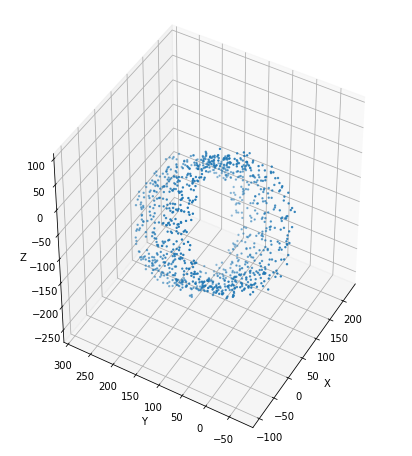

In [5]:
%matplotlib inline
import numpy as np
import skimage.measure as sm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

## teszt adatok (1000 pont)
X1=np.loadtxt("./dat/cyl.dat")

## kirajzoljuk
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, aspect='equal', projection='3d')
ax.scatter(X1[:,0], X1[:,1], X1[:,2], s=2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=40, azim=210)
plt.show()


Az adatok beolvasása és felrajzoltatása után elvégezzük a henger paramétereinek RANSAC becslését. Az esetünkben a `min_samples = 5`. A `residual_threshold` értékére a `10.0` értéket találhatjuk célszerűnek.

In [6]:
ransac_model, inliers = sm.ransac(X1, CylModel, 5, 10.0)

np.set_printoptions(suppress=True)
print ransac_model.params
print "pontok száma : ", X1.shape[0]
print "kivágó pontok: ", X1.shape[0]-np.sum(inliers)

[ 100.6527872169    0.5315482736    0.6334361259   -0.5623300696
  114.4770058482  186.0931126367 -159.2797358391]
pontok száma :  1000
kivágó pontok:  110


Ha az előző számítást többször egymás után megismételjük, akkor most is azt tapasztalhatjuk, hogy minden esetben kissé változnak a becsült paraméterek és a kivágó pontok száma, a RANSAC módszer véletlen jellegéből fakadóan.

Rajzoljuk fel a kapott konszenzus halmazt és piros színnel a kivágó pontokat:

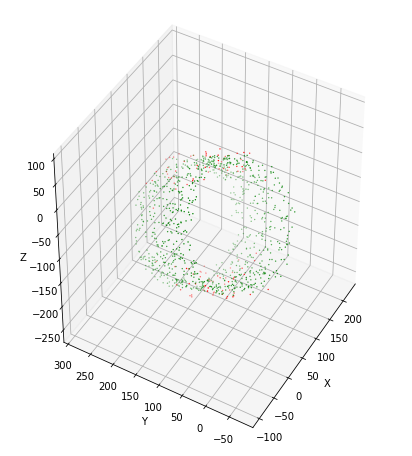

In [7]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, aspect='equal', projection='3d')
ax.scatter(X1[inliers,0], X1[inliers,1], X1[inliers,2], edgecolors='none', c='green',s=2)
outliers = np.invert(inliers)
ax.scatter(X1[outliers,0], X1[outliers,1], X1[outliers,2], edgecolors='none', c='red',s=2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=40, azim=210)
plt.show()

### Illeszkedési eltérések
Rajzoljuk ki az illeszkedési eltérések hisztogramját

átlag : -0.61 %
szórás: 13.25 %
max   : 39.27 %


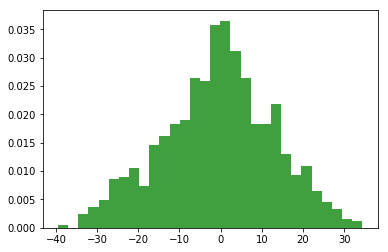

In [8]:
def cyldist(cyl,X,pos=1):
    """
    cyldist(cyl,X) az X pontok előjel nélküli távolságait számítja ki a cyl hengertől
    cyl: 7-elemű vektor:
         r: sugár
         a: henger tengely egységvektora
         f: a henger tengely egy pontjának helyvektora
         X: (n,3) az n pont koordinátáiból alkotott mátrix
         pos: ha pos=0, előjeles távolságokat számít ki, egyébként nem
    """

    r = cyl[0]
    a = cyl[1:4]
    f = cyl[4:]
    xf = X-f
    ## norm squared
    nxf = xf[:,0]**2+xf[:,1]**2+xf[:,2]**2
    if pos==1:
        dist = np.abs(np.sqrt(nxf - ((X-f).dot(a))**2) - r)
    else:
        dist = np.sqrt(nxf - ((X-f).dot(a))**2) - r
    return dist

# előjeles távolságokat számítunk
v = cyldist(ransac_model.params,X1,0)

# sugárhoz viszonyított százalékos eltérések (átlag, szórás)
print "átlag : %.2f %%" % (100*np.mean(v)/ransac_model.params[0])
print "szórás: %.2f %%" % (100*np.std(v)/ransac_model.params[0])

# max. százalékos eltérés
print "max   : %.2f %%" % (100*np.max(np.abs((v)))/ransac_model.params[0])

# relatív eltérsek hisztogramja
fig = plt.figure()
n, bins, patches = plt.hist(v, 30, normed=1, facecolor='green', alpha=0.75)
plt.show()

### Legkisebb négyzetes paraméter becslés a RANSAC eredményei alapján

A henger paramétereinek legjobb RANSAC becslése a maximális konszenzus halmaz elemszám alapján történt. Miután rendelkezünk a konszenzus halmaz elemeivel, ezért további lépésként a konszenzus halmaz alapján finomítani lehet - például a legkisebb négyzetek módszerével - a henger paramétereinek a becslését. Célszerű erre Jiang és Cheng [eljárását](https://pdfs.semanticscholar.org/8b5c/6f662b783093618f50433104b54f2d220f5b.pdf) felhasználni.

Az eljárás lényege az, hogy először az optimálisan illeszkedő henger tengelyének irányát határozzuk meg, hiszen a henger palástjától vett eltérések négyzetösszege nem változik meg, ha pontosan a tengely irányából minden pontot a tengelyre merőleges síkra levetítünk. A vetítési iránytól függő négyzetösszeg számítását az `acfit(X,a)` függvénnyel végezhetjük el az `X` tömb soraiban található tetszőleges számú pontra. A vetítési irányt az `a` vektorban levő $\vartheta$ gömbi poláris szögtávolsággal és $\lambda$ hosszúsággal adjuk meg.


In [12]:
from scipy.optimize import minimize

def acfit(X, a, sonly=False):
    ## acfit(X, a, sonly=False) kört illeszt az X mátrix soraiban megadott, az 'a' tengelyirányban levetítve pontokra 
    ## Input:  X: nx3-as mátrix, az n pont [x,y,z] koordinátái (sorvektorokként tárolva)
    ##         a=[theta, lambda]: a vetítési tengelyirány poláris koordinátái
    ##         sonly: ha True, akkor csak az s-et adja vissza eredményként
    ## Output: s, r, c ahol:
    ##           r: a kör sugara
    ##           c=[x0, y0, z0]: a kör középpontjának koordinátái a vetítés síkjában
    ##           s: a körtől vett eltérések négyzetösszege

    # vetítünk az origón átmenő síkra
    n=X.shape[0]
    t=a[0]
    l=a[1]
    # tengely egységvektora
    au = np.array([np.sin(t)*np.cos(l), np.sin(t)*np.sin(l), np.cos(t)])
    # vetítési síkban fekvő egységvektorok
    ath = np.array([np.cos(t)*np.cos(l), np.cos(t)*np.sin(l), -np.sin(t)])
    ala = np.array([-np.sin(l), np.cos(l), 0])
    # levetített pontok koordinátái
    x = np.sum(X*np.tile(ala,(n,1)),axis=1)
    y = np.sum(X*np.tile(ath,(n,1)),axis=1)
    Xs = np.vstack((x,y)).T

    # M mátrix
    M=np.hstack((-2*Xs,np.ones((n,1))))
    # h vektor
    h=-np.sum(Xs**2,axis=1)
    p,re,ra,ev=np.linalg.lstsq(M,h)
    # kör sugara
    r=np.sqrt(p[0]**2+p[1]**2-p[2])
    # középpont koordinátái a síkon
    cs=p[0:2]
    # visszatranszformáljuk a kör közepét az xyz-rendszerbe
    TR=np.vstack((ala, ath, au)).T
    c=TR.dot(np.hstack((cs, 0)))
    # eltérések négyzetösszege
    s=np.sum((M.dot(p)-h)**2)
    if sonly:
        return s
    else:
        return s, r, c


A legjobban illeszkedő henger meghatározása során a fentebb megadott `acfit` függvény segítségével megadott egysoros `sqsum` függvényt minimalizáljuk a `scipy.optimize` modul `minimize` függvényével. Miután megkaptuk a tengely irányát, levetítjük a pontokat és kiszámítjuk a legjobban illeszkedő henger többi paraméterét is. Mindezeket a `henger(X)` függvénnyel valósítjuk meg:

In [13]:
def henger(X):
    ## henger(X) egyenes körhengert illeszt az X mátrix soraiban megadott pontra
    ## Input:  X: nx3-as mátrix, az n pont [x,y,z] koordinátái (sorvektorokként tárolva)
    ## Output: [c, r, a] ahol:
    ##           r: a henger sugara
    ##           c=[x0, y0, z0]: a henger egy tengelypontjának koordinátái
    ##           a=[theta, lambda]: a henger tengelyének iránya (gömbi poláris koordináták)

    # átlagértékeket levonjuk a koordinátákból
    Xm=np.mean(X,axis=0)
    Xs=X-Xm
    # a pontok száma
    n=X.shape[0]

    # minimumkeresés
    #
    # a célfüggvény
    sqsum = lambda x: acfit(X,x,True)
    x0 = np.array([0.1, 0.1])
    res = minimize(sqsum, x0, method='BFGS')
    x = res.x
    # a paraméterek
    a = x
    au = np.array([np.sin(x[0])*np.cos(x[1]), np.sin(x[0])*np.sin(x[1]), np.cos(x[0])])
    print "a tengely egységvektora: [ %.5f,  %.5f,  %.5f ]" % (au[0], au[1], au[2])
    # vetítési síkban fekvő egységvektorok
    ath = np.array([np.cos(x[0])*np.cos(x[1]), np.cos(x[0])*np.sin(x[1]), -np.sin(x[0])])
    ala = np.array([-np.sin(x[1]), np.cos(x[1]), 0])
    # levetített pontok koordinátái
    x = np.sum(X*np.tile(ala,(n,1)),axis=1)
    y = np.sum(X*np.tile(ath,(n,1)),axis=1)
    # a többi paraméter:
    s, r, c = acfit(Xs, a)
    c = c + Xm
    return c, r, a


A konszenzus halmaz elemei az `X1[inliers,:]`-ben vannak. Ezekkel elvégezzük a legkisebb négyzetes henger paraméter becslést.

In [14]:
c, r, a = henger(X1[inliers,:])
print "tengelypont : ", c
print "sugár       : ", r

a tengely egységvektora: [ -0.42469,  -0.69417,  0.58117 ]
tengelypont :  [  64.5827591684  105.5801817535  -88.87874001  ]
sugár       :  100.050578568


A korábbi értékek ezek voltak:

    [ 100.6527872169    0.5315482736    0.6334361259   -0.5623300696
      114.4770058482  186.0931126367 -159.2797358391]

Látszik, hogy a sugár értéke néhány tizeddel tér el és a tengely egységvektorának előjele ellentétes.